In [1]:
import pandas as pd

# prophet
from prophet import Prophet
from prophet.plot import *

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.pipeline import Pipeline

# warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importar dados
df_ipea = pd.read_csv('/content/drive/MyDrive/PosTech_Analise_de_dados/FASE4/tech_challenge_4/dados/ipeadata_limpo.csv')

In [ ]:
def limpar_df_ipea(df_ipea):
    # Renomear colunas
    df_ipea.rename(columns={
        'Data': 'ds',
        'Preço - petróleo bruto - Brent (FOB)': 'y',
    }, inplace=True)

    # Tranformar coluna data em datetime
    df_ipea['ds'] = pd.to_datetime(df_ipea['ds'], format='%d/%m/%Y')

    # Tranformar valor para float
    df_ipea['y'] = df_ipea['y'].str.replace(',', '.').astype(float)

    # Ordenar os dados por data (do mais antigo para o mais atual)
    df_ipea.sort_values(by=['ds'], ascending=True, inplace=True)


limpar_df_ipea(df_ipea)

In [ ]:
prophet_df_ipea = df_ipea[df_ipea['ds'] >= df_ipea['ds'].max() - pd.DateOffset(years=4)]

In [ ]:
prophet_df_ipea.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [ ]:
train_ipea = prophet_df_ipea.sample(frac=0.8, random_state=0)
test_ipea = prophet_df_ipea.drop(train_ipea.index)
print(f'train: {train_ipea.shape}')
print(f'test: {test_ipea.shape}')

train: (814, 2)
test: (203, 2)


In [ ]:
# Instanciando o Modelo
prophet = Prophet(daily_seasonality=True)

# Treinando o Modelo
prophet.fit(train_ipea)

# Realizando a Previsão 120 dias (4 meses)
df_ipea_prophet = prophet.make_future_dataframe(periods=90, freq='B')
prev_prophet = prophet.predict(df_ipea_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdb97cnf7/q21b_2ov.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdb97cnf7/mk8xezg1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32717', 'data', 'file=/tmp/tmpdb97cnf7/q21b_2ov.json', 'init=/tmp/tmpdb97cnf7/mk8xezg1.json', 'output', 'file=/tmp/tmpdb97cnf7/prophet_models4vxd77u/prophet_model-20240702222024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:20:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:20:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


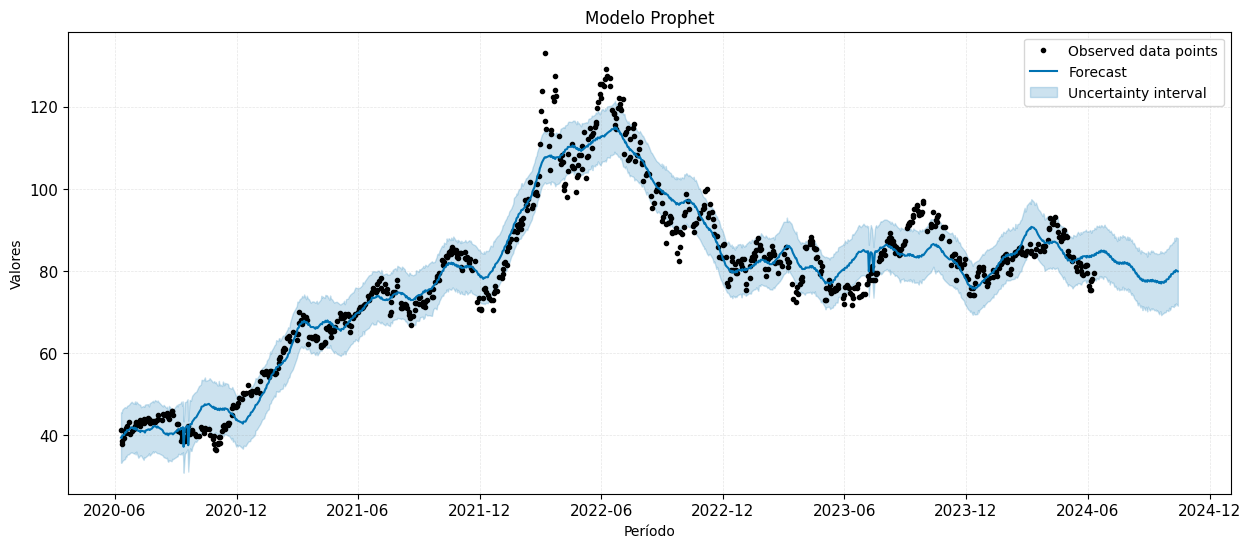

In [ ]:
plt.figure(figsize=(15,6))
prophet.plot(prev_prophet, xlabel='Período', ylabel='Valores', ax=plt.gca())
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Modelo Prophet', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

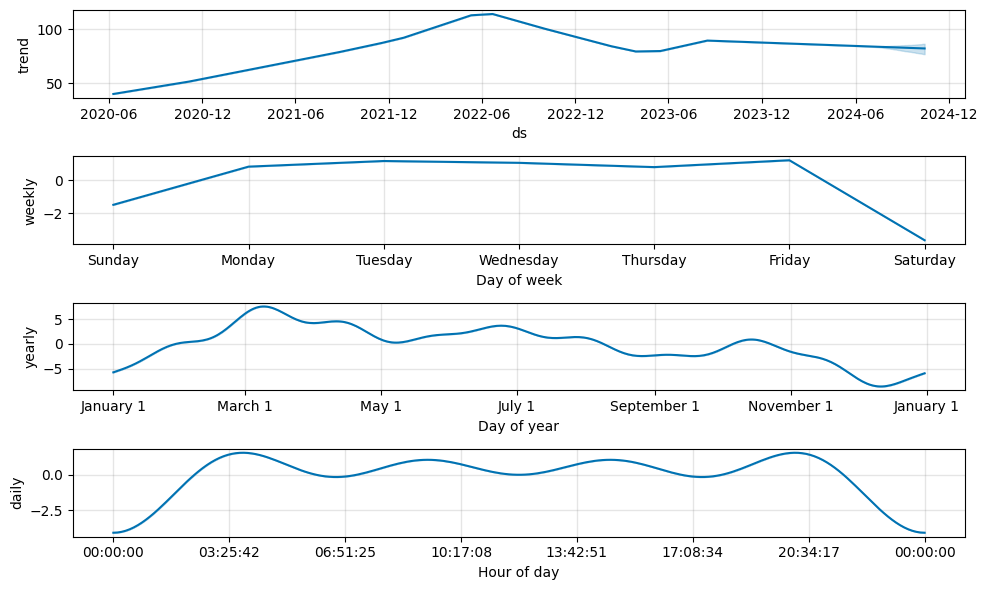

In [ ]:
prophet.plot_components(prev_prophet, figsize=(10,6))
plt.show()

In [ ]:
# Resultados para calcular resultados
result = pd.merge(prev_prophet[['ds', 'yhat']], train_ipea[['ds', 'y']], on='ds', how='inner')

y_result = result['y']
yhat_result = result['yhat']

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_result, yhat_result)
# Calcular o erro absoluto médio (MAE)
mae = mean_absolute_error(y_result, yhat_result)
# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_result, yhat_result)
# Calcular o erro percentual absoluto médio (MAPE)
mape = np.mean(np.abs((y_result - yhat_result) / y_result)) * 100

print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

MSE: 23.11
MAE: 3.66
R²: 0.94
MAPE: 4.80%
